In [3]:
import json
from pathlib import Path
import pandas as pd

# 1) 读取 exp7
root = Path("exp7")
rows = []

for f in root.rglob("*.json"):
    model = f.parent.name
    n = f.parent.parent.name
    kind = "pointwise" if "pointwise" in f.name else "distribution"

    data = json.loads(f.read_text(encoding="utf-8"))
    for domain, metrics in data.items():
        row = {"N": n, "kind": kind, "model": model, "domain": domain}
        row.update(metrics)
        rows.append(row)

df = pd.DataFrame(rows)

print(df.head())
print(df.shape)


    N       kind   model    domain  spearman_rho  spearman_p  js_divergence  \
0  N1  pointwise    Leak  spending        0.1470    0.493193         0.3423   
1  N1  pointwise    Leak     labor       -0.4609    0.023418         0.4723   
2  N1  pointwise    Leak    credit        0.0038    0.985442         0.3088   
3  N1  pointwise  Random  spending        0.1070    0.618881         0.3392   
4  N1  pointwise  Random     labor       -0.3670    0.077754         0.4695   

      rmse    mae  n_samples  n_time_points  \
0   3.1682   2.30      18526           24.0   
1  62.9590  55.36      16476           24.0   
2  22.1839  14.55      27125           25.0   
3   3.1738   2.30      18395           24.0   
4  62.3109  54.72      16476           24.0   

                                      cleaning_stats  coverage_rate  
0  {'original_rows': 26579, 'human_null': 49, 'll...            NaN  
1  {'original_rows': 26803, 'human_null': 10327, ...            NaN  
2  {'original_rows': 27251, 'hum

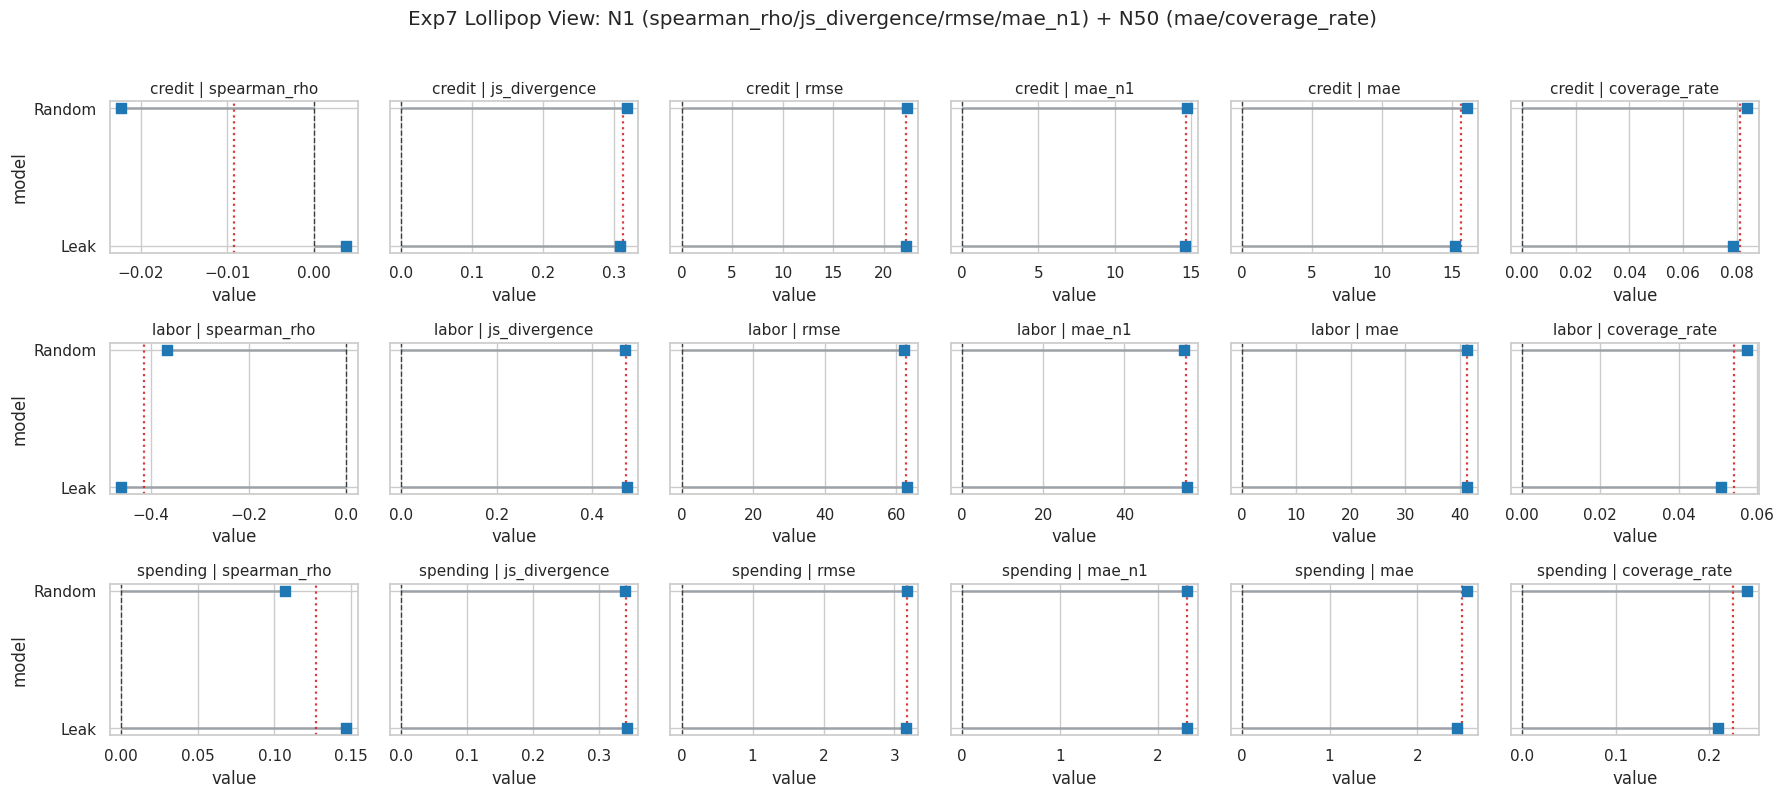

In [4]:
import json
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1) 读取所有 json
root = Path("exp7")
rows = []

for f in root.rglob("*.json"):
    model = f.parent.name
    n = f.parent.parent.name
    kind = "pointwise" if "pointwise" in f.name else "distribution"

    data = json.loads(f.read_text(encoding="utf-8"))
    for domain, metrics in data.items():
        row = {"N": n, "model": model, "kind": kind, "domain": domain}
        row.update(metrics)
        rows.append(row)

df = pd.DataFrame(rows)

# 2) 模型名缩写
def shorten_model(name: str) -> str:
    s = name
    s = s.replace("gpt-5-mini-", "g5m-")
    s = s.replace("gpt_5_mini_", "g5m-")
    s = s.replace("gpt-3.5-", "g3.5-")
    s = s.replace("gemini-3-flash-preview-", "ge3-")
    s = s.replace("gemini_3_flash_", "ge3-")
    s = s.replace("Qwen3-30B-", "q3-")
    s = s.replace("A3B-Instruct-2507-FP8", "-NT")
    s = s.replace("nothinking", "NT")
    s = s.replace("Thinking", "T")
    s = s.replace("thinking", "T")
    s = s.replace("medium", "T")
    s = s.replace("minimal", "NT")
    s = s.replace("turbo", "NT")
    return s

df["model_short"] = df["model"].apply(shorten_model)

# 3) 拼接 N1 + N50 的 6 个指标（含 N1 mae）
n1 = df[(df["kind"] == "pointwise") & (df["N"] == "N1")][
    ["domain", "model_short", "spearman_rho", "js_divergence", "rmse", "mae"]
].copy()
n1 = n1.rename(columns={"mae": "mae_n1"})

n50 = df[(df["kind"] == "distribution") & (df["N"] == "N50")][
    ["domain", "model_short", "mae", "coverage_rate"]
].copy()

merged = pd.merge(n1, n50, on=["domain", "model_short"], how="inner")

metrics_order = ["spearman_rho", "js_divergence", "rmse", "mae_n1", "mae", "coverage_rate"]
plot_long = merged.melt(
    id_vars=["domain", "model_short"],
    value_vars=metrics_order,
    var_name="metric",
    value_name="value"
)

plot_long["metric"] = pd.Categorical(plot_long["metric"], categories=metrics_order, ordered=True)
model_order = sorted(plot_long["model_short"].unique())
domain_order = sorted(plot_long["domain"].unique())

# 4) 棒棒糖图 + 均值引导线 + thinking/非thinking线型区分 + 标红逻辑
sns.set_theme(style="whitegrid", font="DejaVu Sans")

fig, axes = plt.subplots(
    len(domain_order), len(metrics_order),
    figsize=(3.0 * len(metrics_order), 2.6 * len(domain_order)),
    sharex=False, sharey=False
)

if len(domain_order) == 1 and len(metrics_order) == 1:
    axes = [[axes]]
elif len(domain_order) == 1:
    axes = [axes]
elif len(metrics_order) == 1:
    axes = [[ax] for ax in axes]

def line_style(model_short: str) -> str:
    return "--" if "NT" in model_short else "-"

def marker_style(model_short: str) -> str:
    return "o" if "NT" in model_short else "s"

# 方向：1=越大越好，-1=越小越好
metric_dir = {
    "spearman_rho": 1,
    "coverage_rate": 1,
    "js_divergence": -1,
    "rmse": -1,
    "mae": -1,
    "mae_n1": -1,
}

def is_g35_or_qwen(ms: str) -> bool:
    return ("g3.5" in ms) or (ms.startswith("q3-")) or ("qwen" in ms)

def is_gemini3_or_gpt5(ms: str) -> bool:
    return ("ge3-" in ms) or ("g5" in ms)

for i, domain in enumerate(domain_order):
    for j, metric in enumerate(metrics_order):
        ax = axes[i][j]
        sub = plot_long[(plot_long["domain"] == domain) & (plot_long["metric"] == metric)].copy()
        sub["model_short"] = pd.Categorical(sub["model_short"], categories=model_order, ordered=True)
        sub = sub.sort_values("model_short")

        ref_vals = sub[sub["model_short"].apply(is_gemini3_or_gpt5)][["model_short", "value"]]
        has_ref = len(ref_vals) >= 1

        # 每个模型单独画，便于控制线型
        for _, r in sub.iterrows():
            ls = line_style(r["model_short"])
            mk = marker_style(r["model_short"])

            line_color = "#9aa0a6"

            # 只给 gpt3.5 和 qwen 的线做“超过任意一个参考就标红”
            if has_ref and is_g35_or_qwen(r["model_short"]):
                refs = ref_vals["value"].tolist()
                if refs:
                    direction = metric_dir.get(metric, 1)
                    if direction == 1:
                        better = r["value"] > min(refs)
                    else:
                        better = r["value"] < max(refs)
                    if better:
                        line_color = "#d62728"  # 红色

            ax.hlines(
                y=r["model_short"],
                xmin=0,
                xmax=r["value"],
                color=line_color,
                linewidth=1.8,
                linestyle=ls,
                alpha=0.95
            )
            ax.scatter(
                r["value"], r["model_short"],
                s=55, marker=mk, color="#1f77b4", zorder=3
            )

        # 0 参考线
        ax.axvline(0, color="black", linestyle="--", linewidth=1, alpha=0.7)

        # 均值引导线
        mean_val = sub["value"].mean()
        ax.axvline(mean_val, color="#d62728", linestyle=":", linewidth=1.6, alpha=0.9)

        ax.set_title(f"{domain} | {metric}", fontsize=11)
        ax.set_xlabel("value")
        ax.set_ylabel("model" if j == 0 else "")
        if j != 0:
            ax.set_yticklabels([])

fig.suptitle(
    "Exp7 Lollipop View: N1 (spearman_rho/js_divergence/rmse/mae_n1) + N50 (mae/coverage_rate)",
    y=1.02
)
plt.tight_layout()
plt.show()


Saved: resultPic/exp7/exp7.pdf


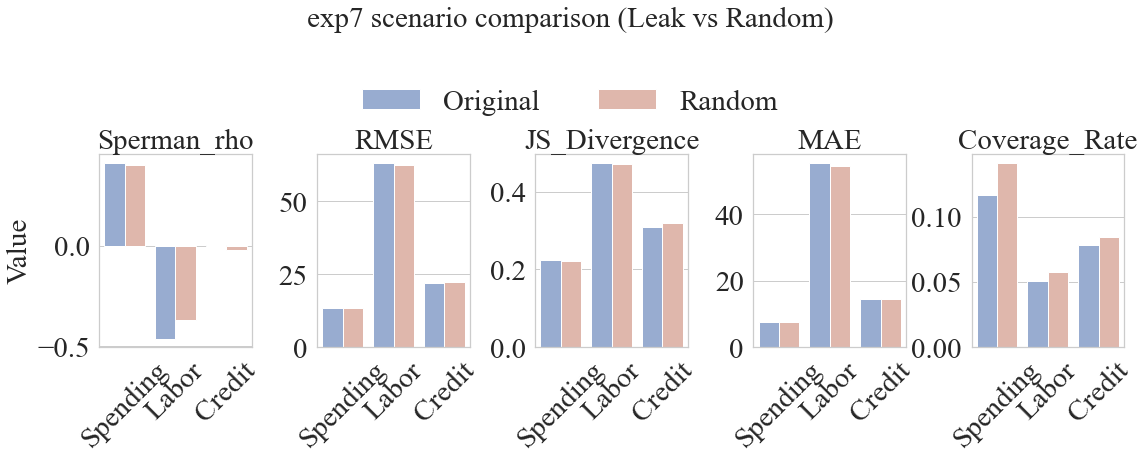

In [1]:
import json
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# 1) 读取 exp7
root = Path("exp7")
rows = []

for f in root.rglob("*.json"):
    scenario = f.parent.name  # Leak / Random
    n = f.parent.parent.name
    kind = "pointwise" if "pointwise" in f.name else "distribution"

    data = json.loads(f.read_text(encoding="utf-8"))
    for domain, metrics in data.items():
        row = {"N": n, "kind": kind, "scenario": scenario, "domain": domain}
        row.update(metrics)
        rows.append(row)

df = pd.DataFrame(rows)

# 2) 分别取 N1 pointwise 和 N50 distribution
sub_n1 = df[(df["N"] == "N1") & (df["kind"] == "pointwise")].copy()
sub_n50 = df[(df["N"] == "N50") & (df["kind"] == "distribution")].copy()

# 3) 指标列表：pointwise + coverage_rate
metrics = ["spearman_rho", "rmse", "js_divergence", "mae", "coverage_rate"]
metrics = [m for m in metrics if m in df.columns]

domain_label_map = {"spending": "Spending", "labor": "Labor", "credit": "Credit"}
metric_label_map = {
    "spearman_rho": "Sperman_rho",
    "js_divergence": "JS_Divergence",
    "rmse": "RMSE",
    "mae": "MAE",
    "coverage_rate": "Coverage_Rate",
}
scenario_label_map = {"Leak": "Original", "Random": "Random"}

def format_scenario(s: str) -> str:
    return scenario_label_map.get(s, s)


def format_domain(d: str) -> str:
    return domain_label_map.get(d, d.title())

def format_metric(m: str) -> str:
    return metric_label_map.get(m, m)

# 4) 将 coverage_rate 用 N50 的替换，其余用 N1
sub = sub_n1.copy()
if "coverage_rate" in metrics:
    cr = sub_n50[["domain", "scenario", "coverage_rate"]].dropna()
    sub = sub.drop(columns=["coverage_rate"], errors="ignore")
    sub = sub.merge(cr, on=["domain", "scenario"], how="left")

# 5) 绘图
sns.set_theme(
    style="whitegrid",
    font="Times New Roman",
    rc={
        "font.size": 29,
        "axes.titlesize": 29,
        "axes.labelsize": 29,
        "xtick.labelsize": 29,
        "ytick.labelsize": 29,
        "legend.fontsize": 29,
        "figure.titlesize": 29,        
    },
)
fig, axes = plt.subplots(1, len(metrics), figsize=(3.3*len(metrics), 6.5), sharey=False)
if len(metrics) == 1:
    axes = [axes]

domain_order = [d for d in ["spending", "labor", "credit"] if d in sub["domain"].unique()]
if not domain_order:
    domain_order = sorted(sub["domain"].unique())
scenario_order = sorted(sub["scenario"].unique())

legend_handles = None
legend_labels = None
for ax, m in zip(axes, metrics):
    plot_sub = sub[["domain", "scenario", m]].dropna().copy()
    plot_sub["domain"] = pd.Categorical(plot_sub["domain"], categories=domain_order, ordered=True)
    plot_sub["scenario"] = pd.Categorical(plot_sub["scenario"], categories=scenario_order, ordered=True)
    plot_sub["domain_display"] = plot_sub["domain"].map(format_domain)
    plot_sub["scenario_display"] = plot_sub["scenario"].map(format_scenario)

    sns.barplot(
        data=plot_sub, x="domain_display", y=m, hue="scenario_display",
        ax=ax, palette=["#8FAAD9", "#E7B2A4"]
    )
    if legend_handles is None:
        legend_handles, legend_labels = ax.get_legend_handles_labels()
    if ax.get_legend() is not None:
        ax.get_legend().remove()
    ax.set_title(format_metric(m))
    ax.set_xlabel("")
    ax.set_ylabel("Value" if ax == axes[0] else "")
    ax.tick_params(axis='x', rotation=45)

fig.suptitle("exp7 scenario comparison (Leak vs Random)", y=1.02)
if legend_handles is not None:
    fig.legend(legend_handles, legend_labels, loc="upper center", bbox_to_anchor=(0.5,0.9), ncol=len(legend_labels), frameon=False)
plt.tight_layout(rect=[0, 0, 1, 0.95])
fig.subplots_adjust(wspace=0.43)

# 保存到 resultPic/exp7/exp7.pdf
out_dir = Path("resultPic") / root.name
out_dir.mkdir(parents=True, exist_ok=True)
out_path = out_dir / f"{root.name}.pdf"
fig.savefig(out_path, dpi=300, bbox_inches="tight")
print("Saved:", out_path)

plt.show()
